In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
from nn_tools import *

from torch.utils.data import Dataset, DataLoader, random_split
#from torch.utils.data.sampler import SubsetRandomSampler as rand_sampler
from torchvision import transforms, datasets

from skorch import NeuralNet

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


from math import ceil
from scipy.stats import randint

seed = 69420
torch.manual_seed(seed)

SAMPLE AT INDEX 125
LABEL: 4


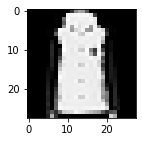

In [5]:
# Define transformation on data: invert the colors of roughly p*100 % of the images.
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomInvert(p=0.78),
        ]) 

full_set = datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transform)

split_prop = 0.8
train_dataset, valid_dataset = random_split(full_set, [ceil(len(full_set)*split_prop), ceil(len(full_set)*(1-split_prop))])
test_dataset = datasets.FashionMNIST('classifier_data', train=False, download=True, transform = transform)

n_train = int(len(train_dataset)/3)
n_test = int(len(test_dataset))

split_idx = int(0.75*n_train)

train_dataloader = DataLoader(train_dataset, batch_size = 2000, num_workers = 12)
val_dataloader = DataLoader(valid_dataset, batch_size = None, num_workers = 12)

test_dataloader = DataLoader(test_dataset, batch_size = None, shuffle = True, num_workers = 12)

sample_index = 125
image = train_dataset[sample_index][0].squeeze()
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(2,2))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

img_shape = tuple(image.shape)
no_labels = len(np.unique(full_set.targets))

In [33]:
in_side = 28
conv1_filters = 16
k_size1 = 3
conv2_filters = 32
k_size2 = 2


def no_params_conv(in_size, kernel, padding, stride):
    """
    Finds no of parameters per channel after every convolution/pooling.
    """
    return int((in_size - kernel + 2*padding)/stride + 1)

params_after_conv1    = no_params_conv(in_side, k_size1, 0, 1)
params_after_maxpool1 = no_params_conv(params_after_conv1,2, 0, 2)
params_after_conv2    = no_params_conv(params_after_maxpool1,k_size2, 0, 1)
params_after_maxpool2 = no_params_conv(params_after_conv2, 2, 0, 2)

features = nn.Sequential(
            nn.Conv2d(1, conv1_filters, k_size1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride = 2),
            nn.BatchNorm2d(conv1_filters),
            nn.Conv2d(conv1_filters, conv2_filters, k_size2), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride = 2),
            nn.BatchNorm2d(conv2_filters)
)

In [35]:
img_in = image.unsqueeze(0).unsqueeze(0)
img_out = features(img_in)

In [66]:
class CNN2d(nn.Module):

    def __init__(self, in_side, conv1_filters, k_size1, conv2_filters, k_size2, Nd1, Nd2, N_labels, init_weight = 'uniform'):
        super(CNN2d, self).__init__()
        self.params_after_conv1    = self.no_params_conv(in_side, k_size1, 0, 1)
        self.params_after_maxpool1 = self.no_params_conv(self.params_after_conv1,2, 0, 2)
        self.params_after_conv2    = self.no_params_conv(self.params_after_maxpool1,k_size2, 0, 1)
        self.params_after_maxpool2 = self.no_params_conv(self.params_after_conv2, 2, 0, 2)

        self.init_weight = init_weight

        self.features = nn.Sequential(
            nn.Conv2d(1, conv1_filters, k_size1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride = 2),
            nn.BatchNorm2d(conv1_filters),
            nn.Conv2d(conv1_filters, conv2_filters, k_size2), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride = 2),
            nn.BatchNorm2d(conv2_filters)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=conv2_filters*self.params_after_maxpool2**2, out_features=Nd1), nn.ReLU(inplace=True), nn.Dropout(p=0.4),
            nn.Linear(in_features=Nd1, out_features=Nd2), nn.ReLU(inplace=True), nn.Dropout(p = 0.2),
            nn.Linear(in_features=Nd2, out_features=N_labels)
        )
        self.features.apply(self.weight_init)
        self.classifier.apply(self.weight_init)
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def weight_init(self, m):
        if self.init_weight == 'normal':
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.bias.data.fill_(0.01)
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
                m.bias.data.fill_(0.01)
        elif self.init_weight == 'uniform':
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_uniform_(m.weight)
                m.bias.data.fill_(0.01)
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    def no_params_conv(self, in_size, kernel, padding, stride):
        """
        Finds no of parameters per channel after every convolution/pooling.
        """
        return int((in_size - kernel + 2*padding)/stride + 1)

In [71]:
from skorch import NeuralNet, scoring

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loss_fn = nn.CrossEntropyLoss()
net = NeuralNet(module = CNN2d, 
    module__in_side = 28, 
    module__conv1_filters = 24,
    module__k_size1 = 4,
    module__conv2_filters = 64,
    module__k_size2 = 2,
    module__Nd1 = 50,
    module__Nd2 = 100,
    module__N_labels = no_labels,
    module__init_weight = "uniform",
    max_epochs = 10,
    optimizer = optim.Adam,
    optimizer__weight_decay = 1e-5,
    criterion = loss_fn,
    lr = 1e-3,
    device = str(device),
    verbose = 1,
)

def score(prediction, true_labels):
    """
    Performs an accuracy scoring of the model's predicted output.
    """

    pred_labels = np.argmax(prediction, axis=1)
    compared_arr = np.equal(pred_labels, true_labels)
    accuracy = sum(compared_arr)/len(compared_arr)
    return accuracy

In [73]:
net.fit(train_dataset)
prediction = net.predict(test_dataset)

true_labels = test_dataset.targets.numpy()
acc = score(prediction, true_labels)

print(f'Model correctly classified {acc*100:.2f}% of the test set.')

Re-initializing module because the following parameters were re-set: N_labels, Nd1, Nd2, conv1_filters, conv2_filters, in_side, init_weight, k_size1, k_size2.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.9723        0.4940  11.7995
      2        0.5995        0.4244  12.4492
      3        0.5050        0.3982  8.9488
      4        0.4613        0.3730  10.8163
      5        0.4240        0.3597  12.7224
      6        0.3970        0.3449  12.2687
      7        0.3786        0.3385  10.6690
      8        0.3637        0.3455  12.4411
      9        0.3457        0.3317  12.3778
     10        0.3360        0.3184  11.9506
Model correctly classified 88.02% of the test set.


Model correctly classified 86.81% of the test set.


In [45]:
net.save_params(f_params='test.pt')

In [46]:
anasda = torch.load('test.pt')

In [48]:
cnn = CNN2d(28,16,4,32,2,36,24,no_labels)
cnn.load_state_dict(torch.load('test.pt'),strict = False)

<All keys matched successfully>

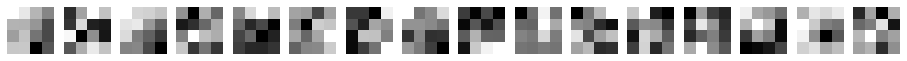

In [55]:
test_conv = cnn.state_dict()['features.0.weight'][0].squeeze(0).squeeze(0).numpy()

fig1, axs1 = plt.subplots(1,cnn.state_dict()['features.0.weight'].shape[0], figsize=(16, 8))
for i, conv_filter in enumerate(cnn.state_dict()['features.0.weight']):
    plot_filter = conv_filter.squeeze(0).squeeze(0).numpy()
    axs1[i].imshow(plot_filter, cmap='gray')
    axs1[i].axis('off')

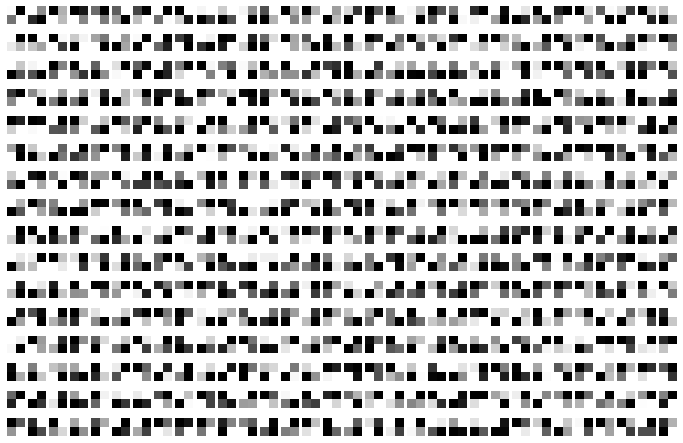

In [59]:
fig2, axs2 = plt.subplots(*tuple(cnn.state_dict()['features.3.weight'].size()[:2][::-1]), figsize = (12, 8))

plot_ct = 0
for filters in cnn.state_dict()['features.3.weight']:
    for conv_filter in filters:
        plot_filter = conv_filter.numpy()
        axs2.flatten()[plot_ct].imshow(plot_filter, cmap='gray')
        axs2.flatten()[plot_ct].axis("off")
        plot_ct+=1

In [28]:
plot_filter

array([[-0.13846958, -0.12198093, -0.02070484],
       [ 0.06028929, -0.07567087,  0.09038912],
       [-0.07370885, -0.08604026, -0.01522909]], dtype=float32)

In [54]:
cnn.state_dict()['model.3.weight'].shape

torch.Size([4, 3, 2, 2])

In [38]:
layer1 = cnn.state_dict()['model.0.weight']
layer1.shape[0]

3

In [45]:
X_val = full_set.data
y_val = full_set.targets

X_val = X_val.unsqueeze(1).type('torch.FloatTensor')

In [50]:
params = {
    'lr' : [0.1, 0.01, 0.001],
    'max_epochs' : [30, 50, 80],
    'module__conv1_filters' : randint(2, 6),
    'module__k_size1' : randint(2, 5),
    'module__conv2_filters' : randint(2, 8),
    'module__k_size2' : randint(2, 4),
    'module__Nd1' : randint(10, 25),
    'module__Nd2' :randint(8, 20),
    'optimizer' : [optim.Adam, optim.Adagrad, optim.SGD]
    }

grid_search = RandomizedSearchCV(net, params, refit = False, n_iter = 6, cv = 4, scoring = 'neg_log_loss', error_score = 'raise')

grid_search.fit(X_val, y_val)

print(grid_search.best_score_, grid_search.best_params_)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1742        0.5687  1.8127
      2        0.5260        0.5152  1.7748
      3        0.4772        0.4850  1.6698
      4        0.4454        0.4640  1.6632
      5        0.4174        0.4339  1.6345
      6        0.3956        0.4194  1.6558
      7        0.3799        0.4078  1.6485
      8        0.3680        0.4001  1.6784
      9        0.3586        0.3953  1.6733
     10        0.3504        0.3913  1.6934
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.4390        0.6819  1.8356
      2        0.6253        0.5942  1.8814
      3        0.5690        0.5551  2.0079
      4        0.5363        0.5329  1.9267
      5        0.5137        0.5181  1.6729
      6        0.4965        0.5074  1.6875
      7        0.4825        0.4989  1.6989
      8        0.4708        0.4916  1.6335
      9        0.4606        0.4

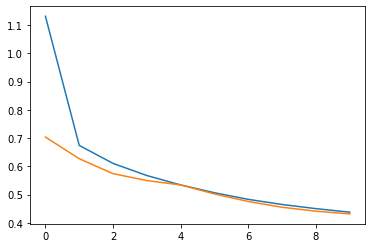

In [176]:
net.history[:, ('train_loss', 'valid_loss')]

plt.plot(range(net.max_epochs), net.history[:, 'train_loss'])
plt.plot(range(net.max_epochs), net.history[:, 'valid_loss'])

In [11]:
cnn = torch.load('CNN_model.pt')

In [10]:
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 0)
test_accuracy = cnn.accuracy(test_dataloader)
print(f"Accuracy on test set: {test_accuracy*100:.3f}%")

Accuracy on test set: 74.800%


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')

